# Implementación de Técnicas de Explicabilidad Basado en “One Explanation Does Not Fit All”

**Objetivo:** Aplicar técnicas de explicabilidad local y global a un modelo de clasificación de fraude crediticio.

## Introducción

La detección de fraude en transacciones financieras es un reto esencial en la industria bancaria y de pagos digitales. Los modelos de machine learning ofrecen alta precisión, pero su “caja negra” genera desafíos para la adopción en ambientes regulados y sensibles. Por ello, la explicabilidad de los modelos es fundamental para generar confianza y cumplir con lineamientos éticos y legales. En este trabajo se implementan y analizan técnicas de explicabilidad local y global sobre un modelo de clasificación binaria de fraude crediticio, siguiendo las recomendaciones del enfoque taxonómico de Arya et al. (2019).

## Importar librerías

In [ ]:
%pip install scikit-learn
%pip install shap

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import shap

## Configuracion de ventana de salida
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set(style="whitegrid")

## Cargar datos

Se utiliza el conjunto de datos **Credit Card Fraud Detection** disponible en [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). Este dataset contiene **284,807 transacciones** de tarjetas de crédito, de las cuales 492 son fraude (~0.17%). Las variables principales son:

- **V1-V28:** Variables numéricas transformadas con PCA (por confidencialidad).
- **Amount:** Monto de la transacción.
- **Time:** Segundos transcurridos desde la primera transacción del dataset.
- **Class:** Variable objetivo (0 = No Fraude, 1 = Fraude).

> **Nota:** El dataset está fuertemente desbalanceado, lo que plantea desafíos adicionales para el modelado y la interpretación.

In [24]:
df = pd.read_csv('creditcard.csv')
print("Shape original:", df.shape)
display(df.head())

Shape original: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,0.09,-0.55,-0.62,-0.99,-0.31,1.47,-0.47,0.21,0.03,0.40,0.25,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,-0.17,1.61,1.07,0.49,-0.14,0.64,0.46,-0.11,-0.18,-0.15,-0.07,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,0.21,0.62,0.07,0.72,-0.17,2.35,-2.89,1.11,-0.12,-2.26,0.52,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,-0.05,-0.23,0.18,0.51,-0.29,-0.63,-1.06,-0.68,1.97,-1.23,-0.21,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,0.75,-0.82,0.54,1.35,-1.12,0.18,-0.45,-0.24,-0.04,0.80,0.41,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


### EDA rápida: Verificar balance de clases

In [3]:
print("\nValores faltantes por columna:\n", df.isnull().sum())
print("\nBalance de clases:\n", df['Class'].value_counts())


Valores faltantes por columna:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Balance de clases:
 Class
0    284315
1       492
Name: count, dtype: int64


## Preparación de datos

- Eliminación de la variable `Time` por no aportar información predictiva directa.
- División estratificada en train y test (80/20) para mantener el balance de clases.

In [4]:
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (227845, 29)
Test shape: (56962, 29)


## Entrenar modelo
- Modelo utilizado: **Random Forest Classifier** (100 árboles, `class_weight='balanced'` para ajustar al desbalance de clases).
- Métricas de desempeño: accuracy, precision, recall, f1-score y matriz de confusión.

In [5]:
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Desempeño del modelo


Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.76      0.85        98

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



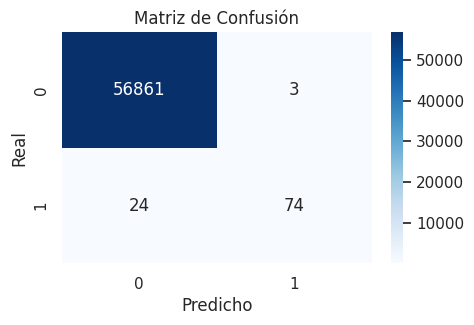

In [6]:
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))
plt.figure(figsize=(5,3))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()

## Técnicas de explicabilidad

- **Local:**  
    - SHAP (SHapley Additive exPlanations) para explicar 5 predicciones individuales.
- **Global:**  
    - SHAP summary plot y bar plot para analizar la importancia general de las variables.
    - Permutation Importance como contraste adicional.

> _Se sigue la taxonomía propuesta en Arya et al. (2019), que sugiere seleccionar técnicas de explicabilidad en función del usuario y del nivel de análisis requerido._

In [7]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

print(shap_values.shape) 

100%|===================| 113792/113924 [04:18<00:00]        

(56962, 29, 2)


### Explicaciones locales (SHAP)
A continuación se muestran las explicaciones locales generadas con SHAP waterfall plot para 5 transacciones individuales, ilustrando el impacto de cada variable en la predicción de fraude:

Instancia 0 - Clase 1 (Fraude):


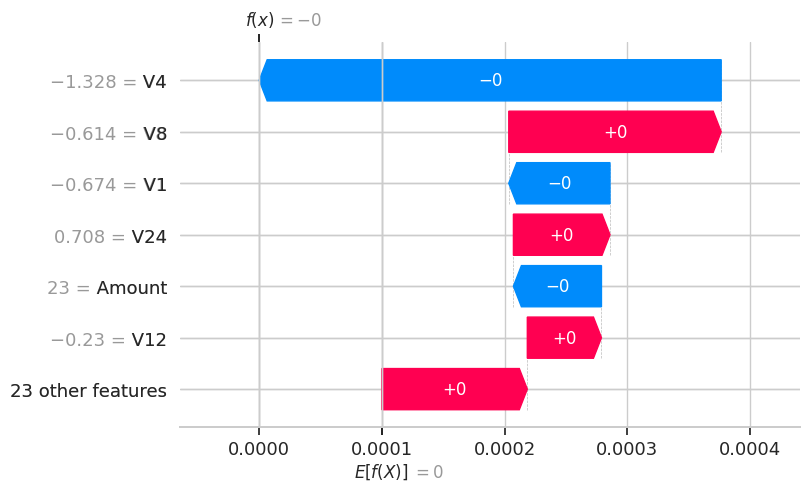

Instancia 1 - Clase 1 (Fraude):


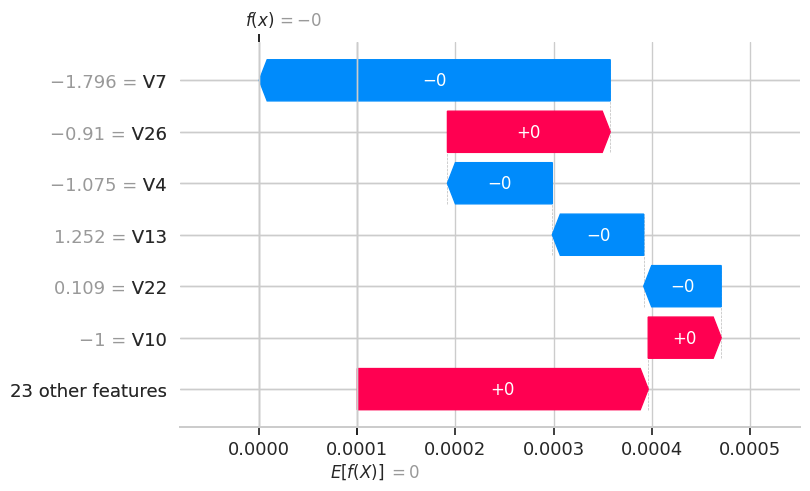

Instancia 2 - Clase 1 (Fraude):


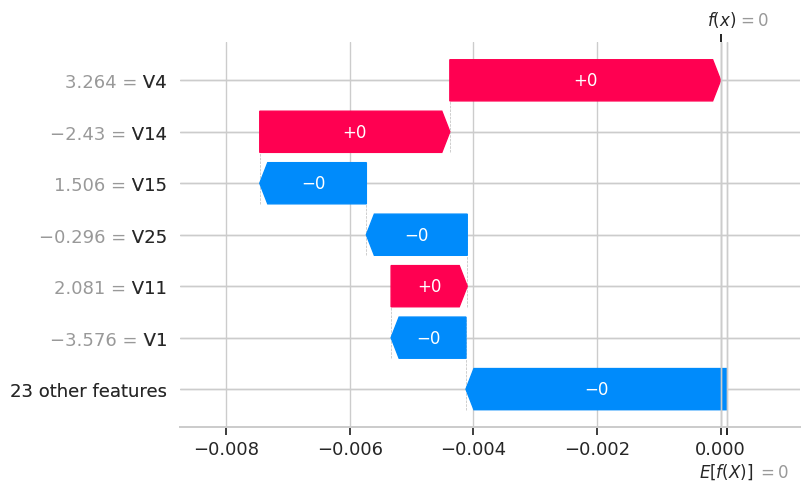

Instancia 3 - Clase 1 (Fraude):


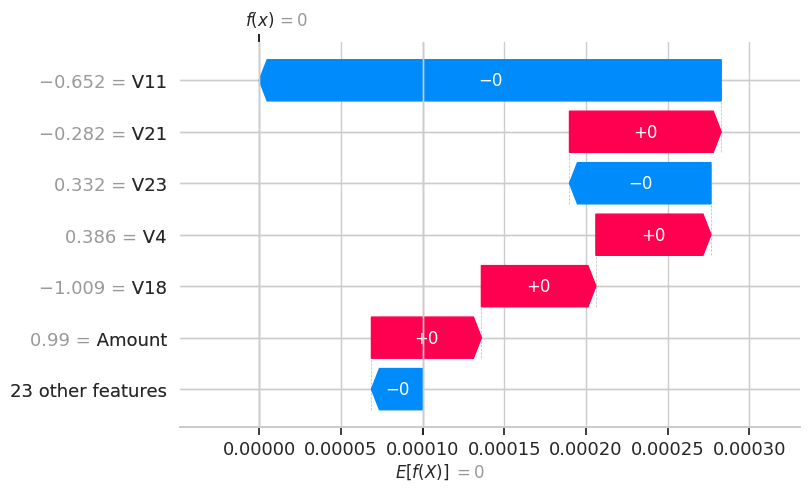

Instancia 4 - Clase 1 (Fraude):


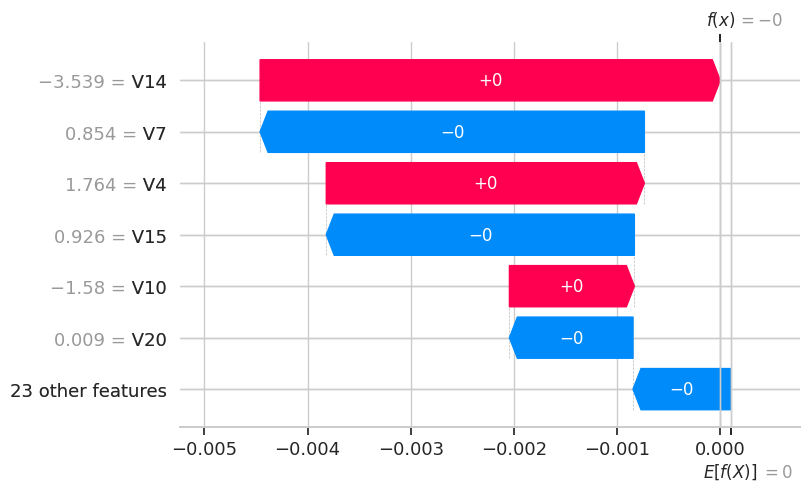

In [23]:
for i in range(5):
    print(f"Instancia {i} - Clase 1 (Fraude):")
    shap.plots.waterfall(shap_values[i, :, 1], max_display=7)

### Explicabilidad global

**Importancia global de características según SHAP:**

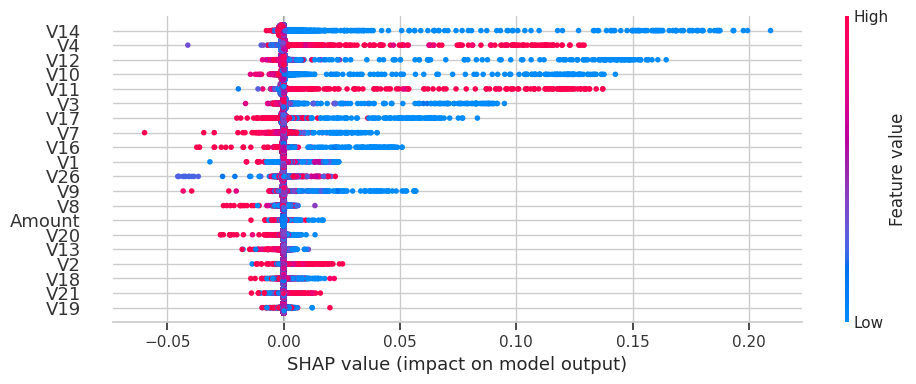

In [19]:
# Para la clase 1 (fraude)
shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=X_test.columns, plot_size=(10, 4))

**Importancia por permutación (Feature Permutation):**

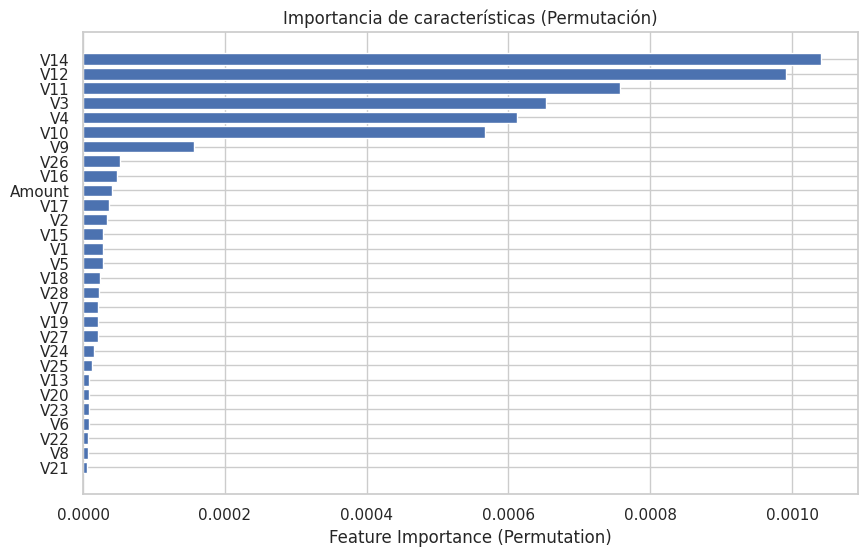

In [25]:
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10,6))
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Feature Importance (Permutation)")
plt.title("Importancia de características (Permutación)")
plt.show()

## Hallazgos y recomendaciones de mejora

- **Variables clave:** SHAP y Permutation Importance coinciden en que V14, V12, V11, V3, V4, V10, V9, V26, V16 y Amount son las variables más influyentes en la predicción de fraude.
- **Decisiones individuales:** Las explicaciones locales muestran cómo valores extremos en variables como V14 y V4 pueden inclinar la predicción hacia "Fraude".
- **Acción recomendada:**
    * Explorar ingeniería de variables sobre las features más relevantes.
    * Experimentar con modelos aún más interpretables si la transparencia es prioritaria (Regresión Logística).
    * Aplicar técnicas de balanceo de clases (como SMOTE) para mejorar recall sobre la clase minoritaria.

## Conclusión
El uso combinado de técnicas de explicabilidad local y global permite entender y auditar las decisiones de modelos de machine learning en la detección de fraude, tanto a nivel de predicción individual como en tendencias globales del modelo.
Estas técnicas aportan transparencia y confianza, facilitando la justificación ante usuarios finales y reguladores, en línea con las mejores prácticas recomendadas por Arya et al. (2019).

## Referencias

Arya, V., Bellamy, R. K., Chen, P. Y., Dhurandhar, A., Hind, M., Hoffman, S. C., ... & Zhang, Y. (2019). One Explanation Does Not Fit All: A Toolkit and Taxonomy of AI Explainability Techniques. *arXiv preprint arXiv:1909.03012*. [https://arxiv.org/abs/1909.03012](https://arxiv.org/abs/1909.03012)